In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, create_mog
from distributions import log_prob_banana as log_p
from util import acf, ess, estimate_log_z
from math import log, pi, sqrt, exp
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange
import numpy as np
from scipy.integrate import quad
from samplers.mcmc import HMC
from pathlib import Path
%matplotlib inline

In [27]:
distrib = 'banana'
component = 'MVNIso'
lam = 4.487
chain = 0

file = Path('results') / f"hmc_{distrib}_{component}_{lam:.3f}_{chain:03d}.dat"
hmc_results = torch.load(file)

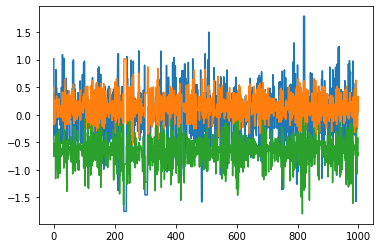

In [28]:
plt.plot(hmc_results['samples'])

In [29]:
full_mixture = create_mog([MVNIso(theta=th) for th in hmc_results['samples']])

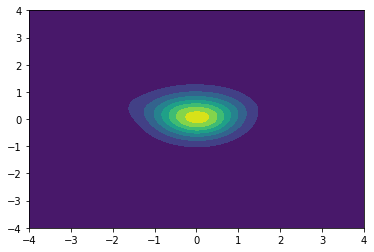

In [30]:
x_grid = torch.linspace(-4,4,301)
xx, yy = torch.meshgrid(x_grid, x_grid)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=1)
plt.contourf(xx, yy, full_mixture.log_prob(xy).exp().reshape(xx.size()))

Estimate $MI[x;\theta]$ using the 'full' mixture

In [31]:
def mixture_entropy(mog, n):
    sample_x = mog.sample((n,))
    log_m_x = mog.log_prob(sample_x)
    entropy_m = -log_m_x.mean().item()
    entropy_m_mcse = log_m_x.std().item() / sqrt(n)
    return entropy_m, entropy_m_mcse

def mixture_kl(mog_q, mog_p, n):
    sample_x = mog_q.sample((n,))
    log_q_x = mog_q.log_prob(sample_x)
    log_p_x = mog_p.log_prob(sample_x)
    log_diff = (log_q_x - log_p_x)
    return log_diff.mean().item(), log_diff.std().item() / sqrt(n)

In [40]:
n_entropy_samples = 5000
entropy_m, entropy_m_mcse = mixture_entropy(full_mixture, n_entropy_samples)
print("H[m] is ", entropy_m, "±", entropy_m_mcse)

each_entropy_q = torch.tensor([MVNIso(theta=th).entropy() for th in hmc_results['samples']])
avg_entropy_q = each_entropy_q.mean().item()
avg_entropy_q_mcse = each_entropy_q.std().item() / sqrt(ess(each_entropy_q.view(-1,1)).item())
print("E[H[q]] is ", avg_entropy_q, "±", avg_entropy_q_mcse)

true_mi = entropy_m - avg_entropy_q
true_mi_mcse = sqrt(entropy_m_mcse**2 + avg_entropy_q_mcse**2)
print("MI[x;θ] is", true_mi, "±", true_mi_mcse)

H[m] is  2.114039421081543 ± 0.01562667069708229
E[H[q]] is  1.4995157718658447 ± 0.018223726305272143
MI[x;θ] is 0.6145236492156982 ± 0.024006187484157455


In [41]:
t_values = torch.arange(20, dtype=torch.int)+1
runs = 100
kl_mt_m = torch.zeros(runs, len(t_values))
kl_mt_m_mcse = torch.zeros(runs, len(t_values))
for j, t in enumerate(t_values):
    for i in range(runs):
        idx = torch.randint(hmc_results['samples'].size(0), size=(t,))
        mixture_t = create_mog([MVNIso(theta=th) for th in hmc_results['samples'][idx, :]])
        # Compute KL(m_T || m)
        kl_mt_m[i,j], kl_mt_m_mcse[i,j] = mixture_kl(mixture_t, full_mixture, n_entropy_samples)

In [42]:
avg_kl_mt_m = kl_mt_m.mean(dim=0)
avg_kl_mt_m_mcse = (kl_mt_m.std(dim=0)**2/runs + (kl_mt_m_mcse**2).mean(dim=0)).sqrt()

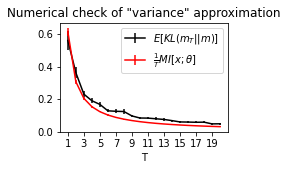

In [48]:
plt.figure(figsize=(3,2))
plt.errorbar(t_values, y=avg_kl_mt_m, yerr=avg_kl_mt_m_mcse, color='k')
plt.errorbar(t_values, y=true_mi/t_values, yerr=true_mi_mcse/t_values, color='r')
plt.legend([r'$E[KL(m_T||m)]$', r'$\frac{1}{T}MI[x;\theta]$'])
plt.xticks(t_values[::2])
plt.xlabel('T')
plt.title('Numerical check of "variance" approximation')
plt.savefig('numerical_variance_approx.svg')